In [1]:
import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np
import anndata
import petsc4py

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

In [2]:
import warnings
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

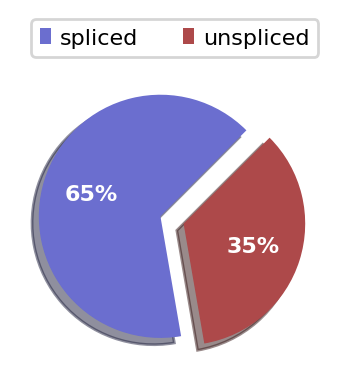

AnnData object with n_obs × n_vars = 3774 × 27339
    obs: 'Clusters', '_X', '_Y', 'seurat_cluster', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'velocity_gamma', 'velocity_r2', 'velocity_genes'
    uns: 'neighbors', 'pca', 'seurat_cluster_colors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'unspliced', 'variance_velocity', 'velocity'
    obsp: 'connectivities', 'distances'

In [3]:
adata = anndata.read_h5ad("/home/lab401_B/scRNA_downstream/cellrank/scRNA_pig_oogenesis/Pig_ovary_granulosa_final.h5ad")
scv.pl.proportions(adata)
adata

## Pre-process the data
### Filter out genes which don’t have enough spliced/unspliced counts, normalize and log transform the data and restrict to the top highly variable genes. 

In [4]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 16019 genes that are detected 20 counts (shared).
Extracted 2000 highly variable genes.
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [5]:
adata

AnnData object with n_obs × n_vars = 3774 × 2000
    obs: 'Clusters', '_X', '_Y', 'seurat_cluster', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'velocity_gamma', 'velocity_r2', 'velocity_genes', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'neighbors', 'pca', 'seurat_cluster_colors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'unspliced', 'variance_velocity', 'velocity'
    obsp: 'connectivities', 'distances'

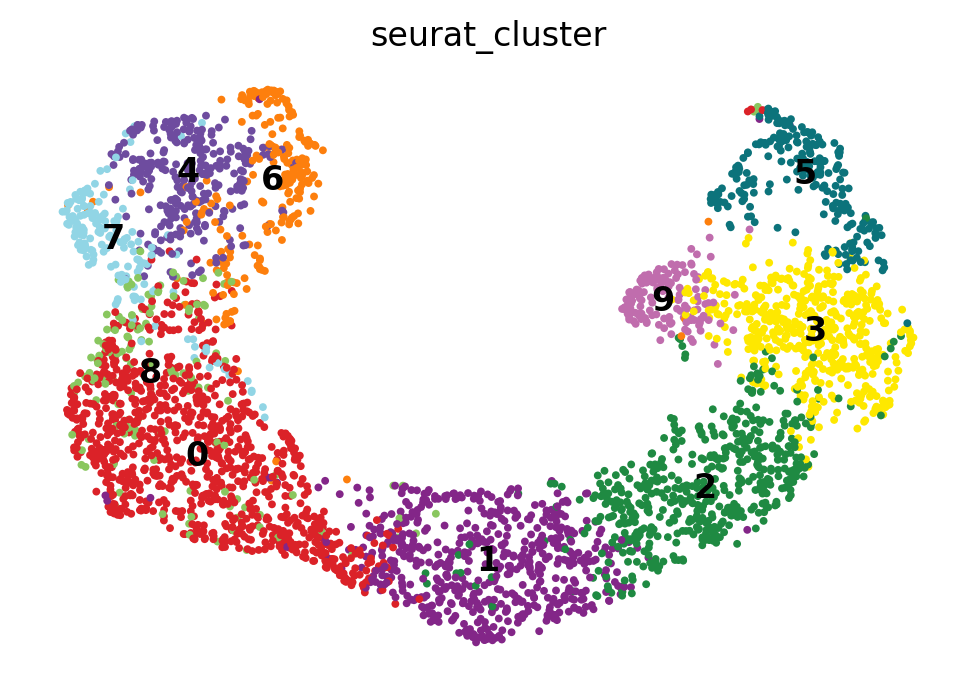

In [6]:
sc.pl.umap(adata, color='seurat_cluster', legend_loc='on data', frameon=False)

## Run scVelo

In [7]:
scv.tl.recover_dynamics(adata, n_jobs=30)

recovering dynamics (using 30/48 cores)


  0%|          | 0/827 [00:00<?, ?gene/s]

    finished (0:00:40) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [8]:
scv.tl.velocity(adata, mode="dynamical")
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:05) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/48 cores)


  0%|          | 0/3774 [00:00<?, ?cells/s]

    finished (0:00:11) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_scVelo_cluster.pdf


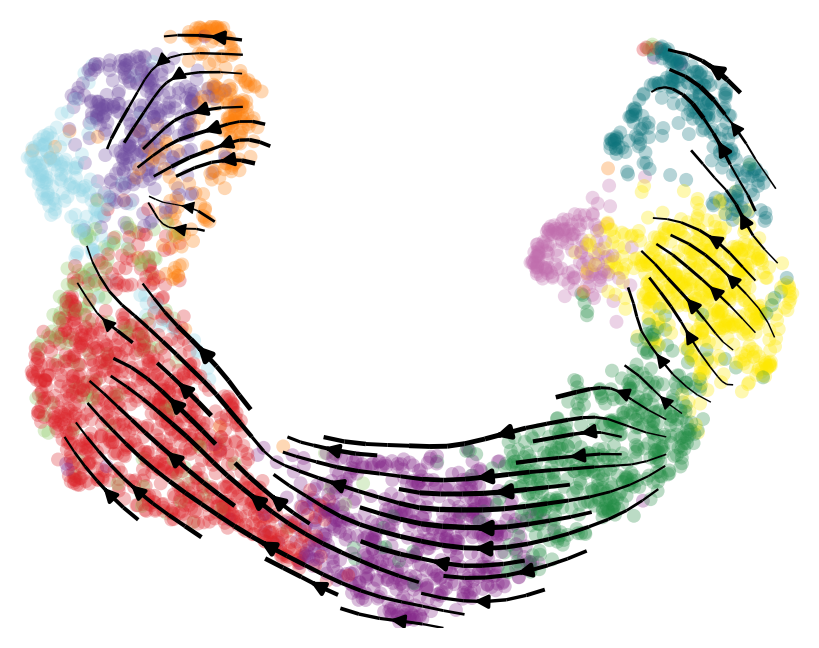

In [9]:
scv.settings.set_figure_params(figsize=(5,4))
scv.pl.velocity_embedding_stream(
    adata, basis="umap", legend_loc='none', color='seurat_cluster',density=1.2, ## 箭头密度
    legend_fontsize=12, title="", smooth=0.8, min_mass=4,size=100,save="scVelo_cluster.pdf"
)

## Run CellRank

## Identify initial states

Accessing `adata.obsp['T_bwd']`
Computing transition matrix based on logits using `'deterministic'` mode


/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.initial_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/cellrank/tl/_init_term_states.py:161: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  **kwargs,


Estimating `softmax_scale` using `'deterministic'` mode


  0%|          | 0/3774 [00:00<?, ?cell/s]

Setting `softmax_scale=6.8603`


  0%|          | 0/3774 [00:00<?, ?cell/s]

    Finish (0:00:13)
Using a connectivity kernel with weight `0.2`
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)
Computing eigendecomposition of the transition matrix
Adding `adata.uns['eigendecomposition_bwd']`
       `.eigendecomposition`
    Finish (0:00:20)
For 1 macrostate, stationary distribution is computed
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Adding `adata.obs['initial_states']`
       `adata.obs['initial_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


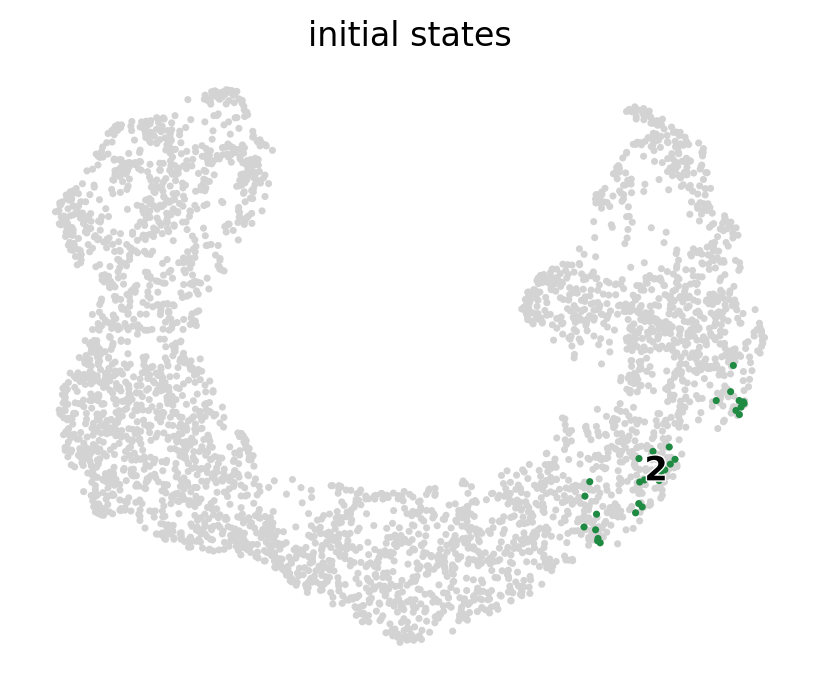

In [12]:
cr.tl.initial_states(adata, cluster_key="seurat_cluster",n_states=1)
cr.pl.initial_states(adata, discrete=True,basis="umap")

## Compute fate maps

Computing absorption probabilities


/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.lineages` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.


  0%|          | 0/3 [00:00<?, ?/s]

Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:00:01)


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger


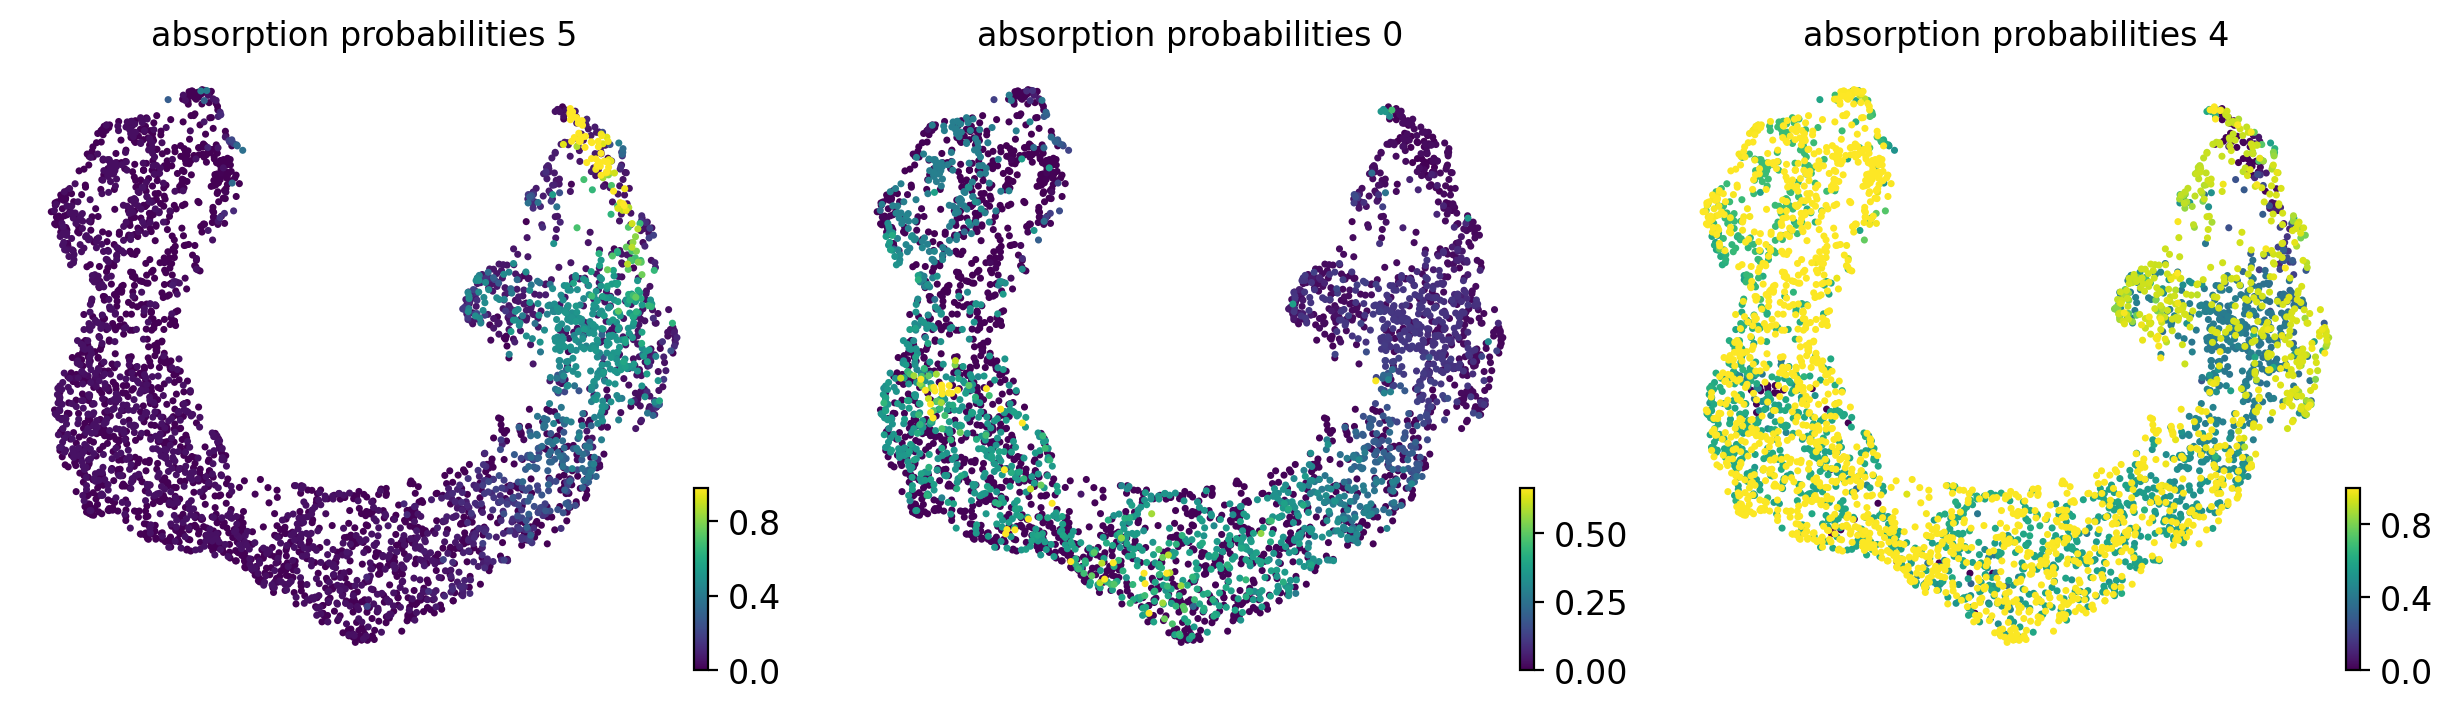

In [13]:
cr.tl.lineages(adata)
cr.pl.lineages(adata, same_plot=False)

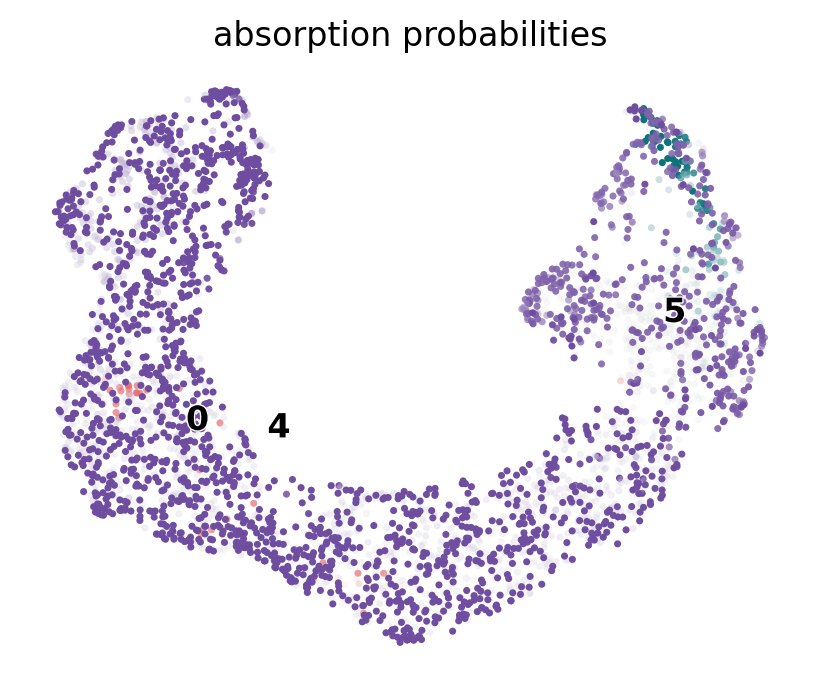

In [14]:
cr.pl.lineages(adata, same_plot=True)

## Directed PAGA

In [15]:
adata.obs["terminal_states_probs"]

E45:AAACCCAAGAGGGCGAx    0.989526
E45:AAACCCAAGTGGCCTCx    0.990786
E45:AAACCCAGTTTAAGGAx    0.977491
E45:AAACGAAAGAGGGTGGx    0.990758
E45:AAACGCTAGAAGGCTCx    0.977868
                           ...   
E75:TTTCGATTCTGTGCGGx    0.968587
E75:TTTGGAGAGTCAGCGAx    0.908089
E75:TTTGGAGCACTCATAGx    0.940327
E75:TTTGGAGGTATGAGGCx    0.792060
E75:TTTGTTGCAGCATCTAx    0.923104
Name: terminal_states_probs, Length: 3774, dtype: float64

In [16]:
scv.tl.recover_latent_time(
    adata, root_key="initial_states_probs", end_key="terminal_states_probs"
)

computing latent time using initial_states_probs, terminal_states_probs as prior
    finished (0:00:05) --> added 
    'latent_time', shared time (adata.obs)


## Compute lineage drivers

In [21]:
cr.tl.lineage_drivers(adata,use_raw=True)

Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)


/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.lineage_drivers` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.


5_corr         5_pval         5_qval  5_ci_low  5_ci_high  \
LGALS9        0.525390  2.008774e-281  1.339183e-278  0.501897   0.548108   
MX1           0.518007  8.397483e-272  4.198741e-269  0.494270   0.540972   
KCNIP4        0.500506  4.833163e-250  1.933265e-247  0.476205   0.524043   
GNG2          0.480063  2.265565e-226  5.663913e-224  0.455128   0.504246   
LOC100626247  0.479921  3.267683e-226  7.261519e-224  0.454981   0.504107   
...                ...            ...            ...       ...        ...   
COL6A2       -0.479046  3.062413e-225  6.124827e-223 -0.503260  -0.454081   
CDKN1C       -0.483698  1.893884e-230  5.411096e-228 -0.507768  -0.458874   
IGFBP7       -0.496324  4.732004e-245  1.577335e-242 -0.519996  -0.471891   
GSTA4        -0.543572  2.608062e-306  2.608062e-303 -0.565668  -0.520697   
PTN          -0.568129   0.000000e+00   0.000000e+00 -0.589352  -0.546122   

                0_corr         0_pval         0_qval  0_ci_low  0_ci_high  \
LGALS9        0.444406  3.680121e-189  2.164777e-187  0.418433   0.469653   
MX1           0.700762   0.000000e+00   0.000000e+00  0.684153   0.716645   
KCNIP4        0.120813   8.962725e-14   3.325687e-13  0.089251   0.152133   
GNG2          0.138188   1.335805e-17   5.858792e-17  0.106753   0.169347   
LOC100626247  0.633239   0.000000e+00   0.000000e+00  0.613733   0.651973   
...                ...            ...            ...       ...        ...   
COL6A2       -0.392394  5.250151e-143  2.282674e-141 -0.419054  -0.365059   
CDKN1C        0.159008   6.992681e-23   3.831606e-22  0.127750   0.189950   
IGFBP7       -0.371331  9.883291e-127  3.188158e-125 -0.398515  -0.343494   
GSTA4        -0.085622   1.358048e-07   3.446823e-07 -0.117208  -0.053863   
PTN          -0.092681   1.144450e-08   3.135479e-08 -0.124220  -0.060956   

                4_corr         4_pval         4_qval  4_ci_low  4_ci_high  
LGALS9       -0.693174   0.000000e+00   0.000000e+00 -0.709391  -0.676223  
MX1          -0.860750   0.000000e+00   0.000000e+00 -0.868796  -0.852249  
KCNIP4       -0.456056  8.831959e-201  4.014527e-199 -0.480963  -0.430413  
GNG2         -0.452493  3.577689e-197  1.555517e-195 -0.477505  -0.426748  
LOC100626247 -0.786659   0.000000e+00   0.000000e+00 -0.798523  -0.774184  
...                ...            ...            ...       ...        ...  
COL6A2        0.623380   0.000000e+00   0.000000e+00  0.603477   0.642507  
CDKN1C        0.254536   1.705436e-57   1.445285e-56  0.224453   0.284135  
IGFBP7        0.622084   0.000000e+00   0.000000e+00  0.602129   0.641262  
GSTA4         0.464517  1.534006e-209  7.670032e-208  0.439119   0.489173  
PTN           0.487656  5.939563e-235  3.299757e-233  0.462953   0.511602  

[2000 rows x 15 columns]

In [22]:
adata

AnnData object with n_obs × n_vars = 3774 × 2000
    obs: 'Clusters', '_X', '_Y', 'seurat_cluster', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'terminal_states', 'terminal_states_probs', 'clusters_gradients', 'initial_states', 'initial_states_probs', 'velocity_pseudotime', 'latent_time'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'velocity_gamma', 'velocity_r2', 'velocity_genes', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'fit_r2'
    uns: 'neighbors', 'pca', 'seurat_cluster_colors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'recover_dynamics', 'T_fwd_params', 'schur_matrix_fwd', 'eigendecomposition_fwd', 'coarse_fwd', 'terminal_states_

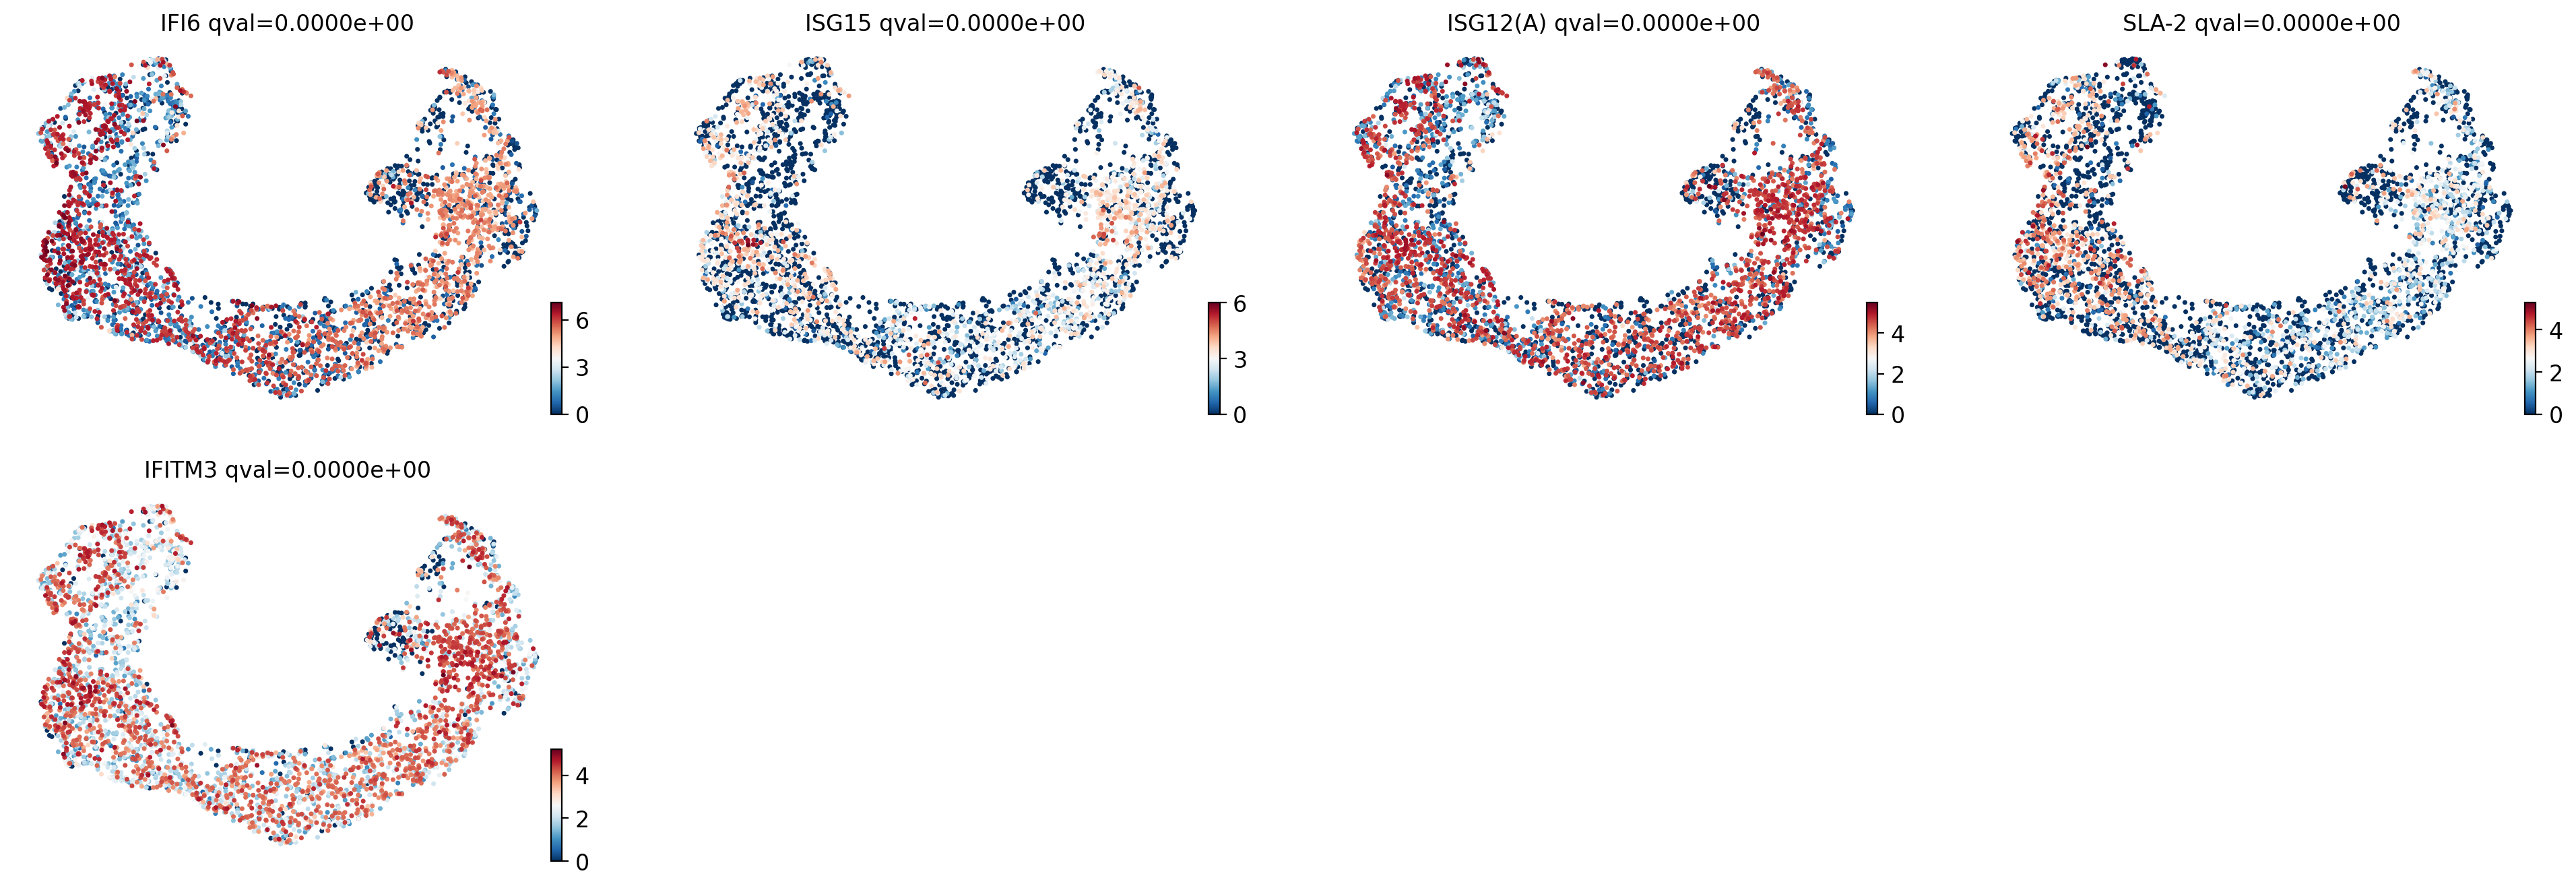

In [23]:
cr.pl.lineage_drivers(adata, lineage="0", n_genes=5)

## Gene expression trends

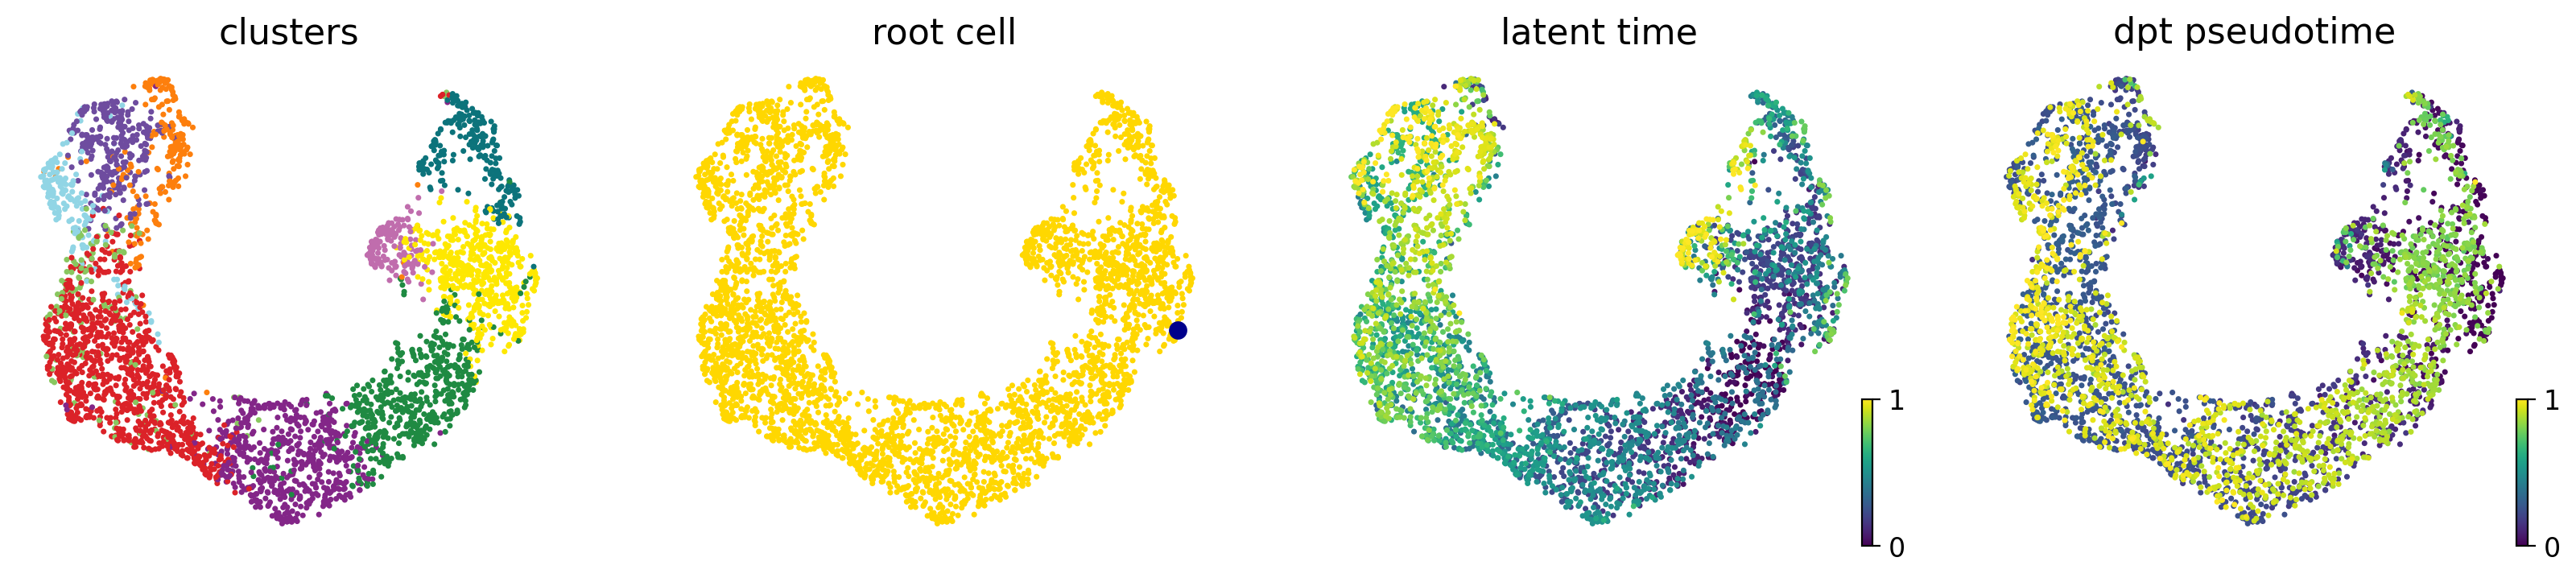

In [24]:
# compue DPT, starting from CellRank defined root cell
root_idx = np.where(adata.obs["initial_states"] == "2")[0][0]
adata.uns["iroot"] = root_idx
sc.tl.dpt(adata)

scv.pl.scatter(
    adata,
    color=["seurat_cluster", root_idx, "latent_time", "dpt_pseudotime"],
    fontsize=16,
    cmap="viridis",
    perc=[2, 98],
    colorbar=True,
    rescale_color=[0, 1],
    title=["clusters", "root cell", "latent time", "dpt pseudotime"],
)

In [25]:
cr.ul.models.GAM(adata)

<GAM[gene=None, lineage=None, model=GammaGAM(callbacks=['deviance', 'diffs'], fit_intercept=True, max_iter=2000, scale=None, terms=s(0), tol=0.0001, verbose=False)]>

In [26]:
model = cr.ul.models.GAM(adata)

Computing trends using `1` core(s)


  0%|          | 0/7 [00:00<?, ?gene/s]

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

    Finish (0:00:00)


/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

Plotting trends


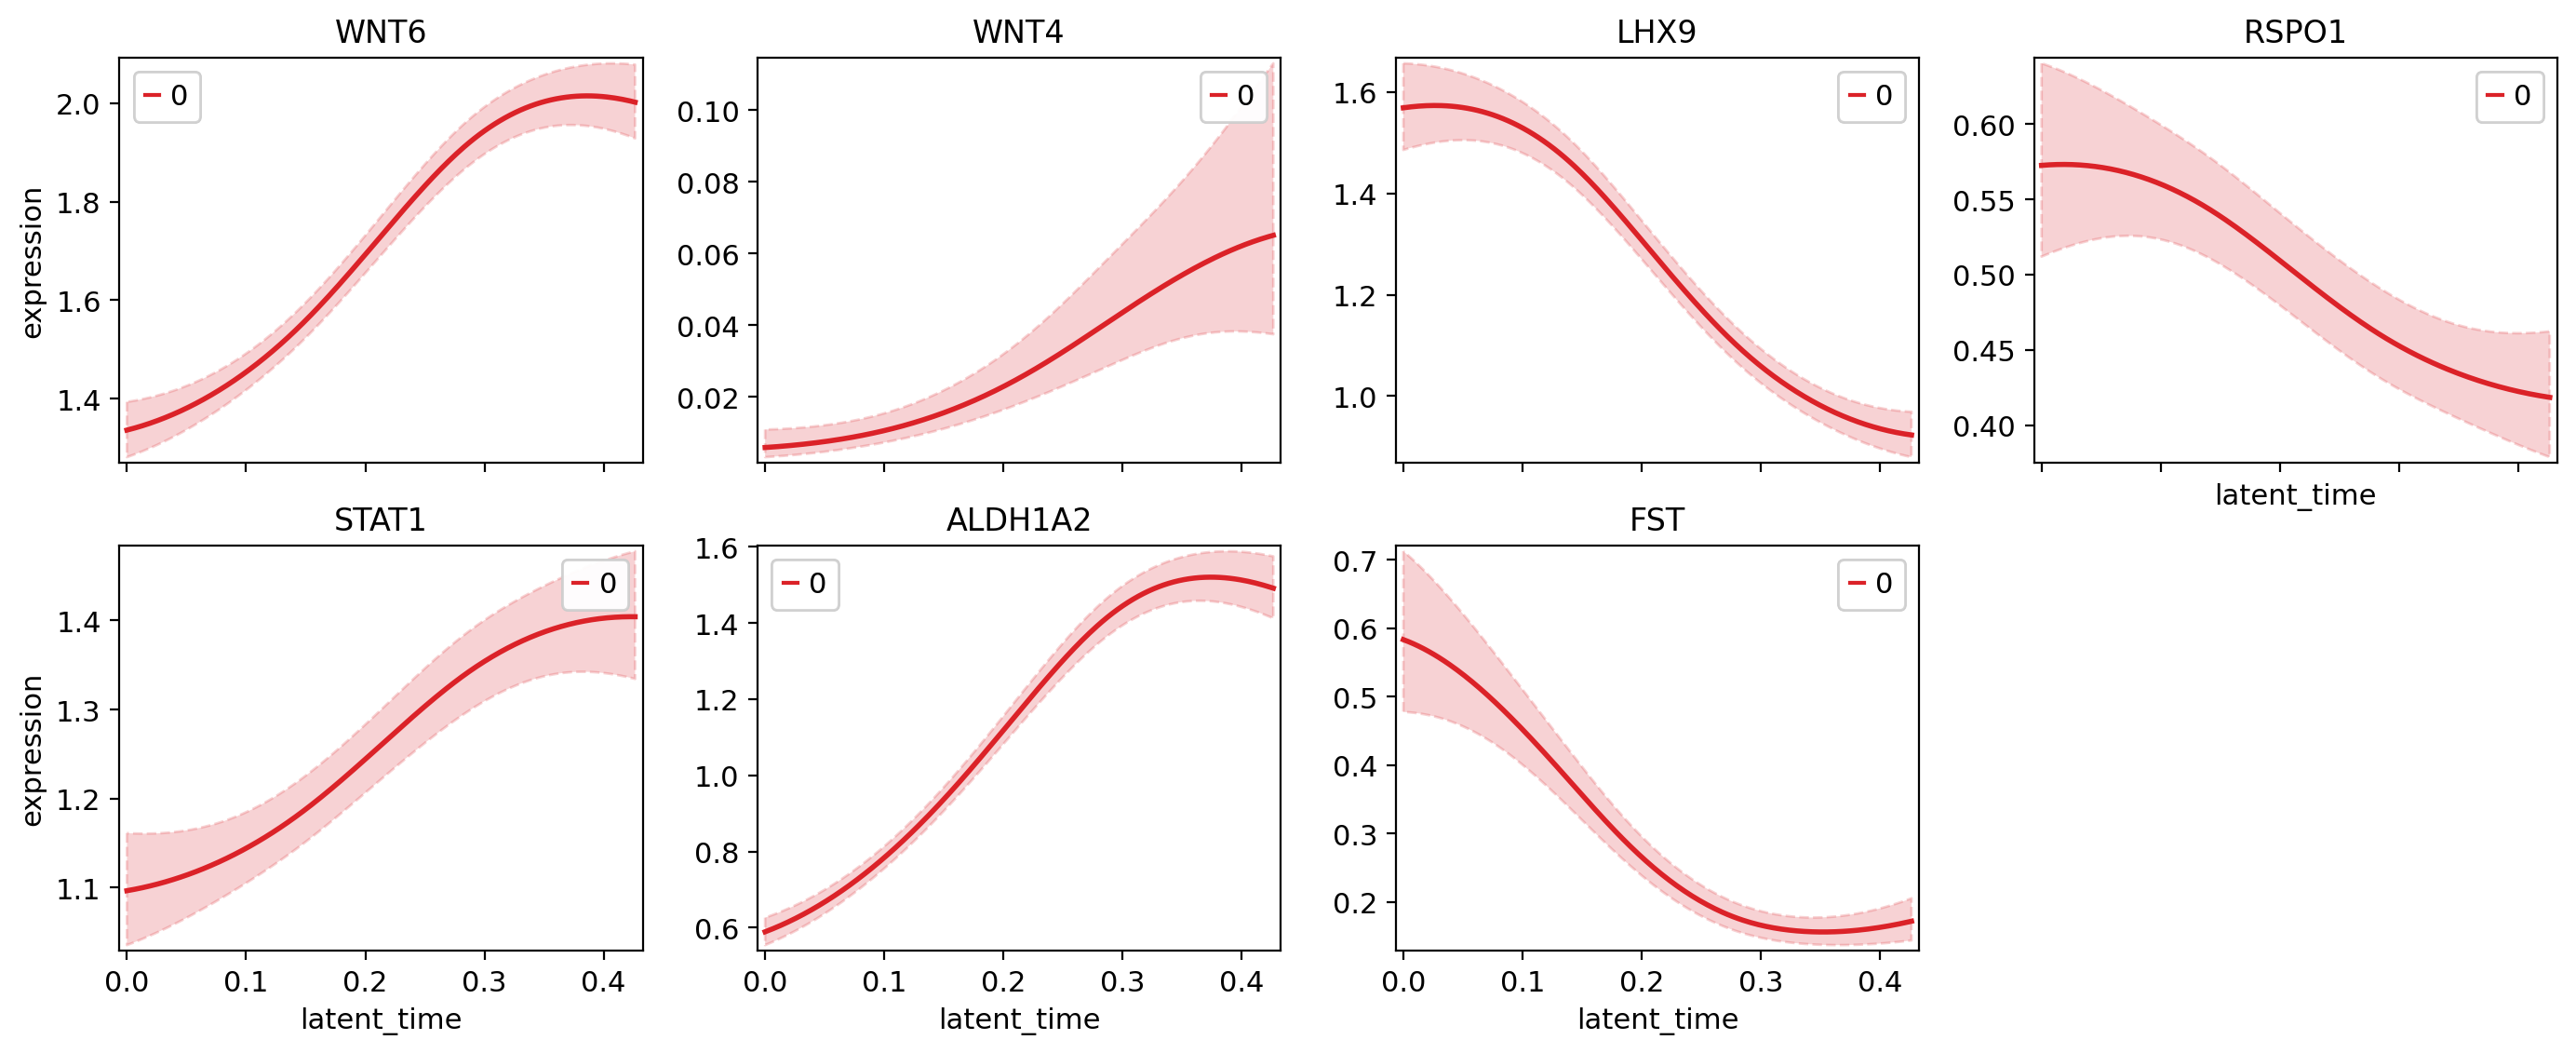

In [33]:
cr.pl.gene_trends(
    adata,
    model=model,
    data_key="X",
    lineages="0", 
    genes=["WNT6", "WNT4","LHX9","RSPO1","STAT1","ALDH1A2","LHX9","FST"],
    ncols=4,
    time_key="latent_time",
    same_plot=True,
    hide_cells=True,
    figsize=(14, 6),
    n_test_points=200,
    save="gene_expression_new.pdf"
)
# cell reports ref
#cr.pl.gene_trends(adata, model=model, data_key='Ms',
#                  genes=['Id3', 'Vim', 'Cntn2', 'Chat', 'Calb2'], ncols=3,
#                  time_key='latent_time', same_plot=True, hide_cells=True,
#                 legend_loc=(1.1 ,0),
#                  figsize=(12,4), n_test_points=200, save= 'marker_gene_latent_time.pdf')



In [42]:
adata

AnnData object with n_obs × n_vars = 3774 × 2000
    obs: 'Clusters', '_X', '_Y', 'seurat_cluster', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'terminal_states', 'terminal_states_probs', 'clusters_gradients', 'initial_states', 'initial_states_probs', 'velocity_pseudotime', 'latent_time', 'dpt_pseudotime'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'velocity_gamma', 'velocity_r2', 'velocity_genes', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'fit_r2'
    uns: 'neighbors', 'pca', 'seurat_cluster_colors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'recover_dynamics', 'T_fwd_params', 'schur_matrix_fwd', 'eigendecomposition_fwd', 'coarse_fwd',

Computing trends using `1` core(s)


  0%|          | 0/15 [00:00<?, ?gene/s]

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

    Finish (0:00:01)


/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

5        0        4
0     TULP4     ESR1     HEY2
1      ESR1    SYNJ2    NCOA7
2     NCOA7    ENPP1  AKIRIN2
3   TNFAIP3  AKIRIN2  PLEKHG1
4     ACAT2    LAMA2    LAMA2
5   PHACTR2    NCOA7    ACAT2
6    AKAP12    ACAT2    TULP4
7     SYNJ2    TULP4    SYNJ2
8      GJA1   AKAP12     ESR1
9   PLEKHG1  PLEKHG1   AKAP12
10    ENPP1  PHACTR2  PHACTR2
11    LAMA2  TNFAIP3  TNFAIP3
12     HEY2     HEY2    ENPP1
13   CEP162     GJA1     GJA1
14  AKIRIN2   CEP162   CEP162

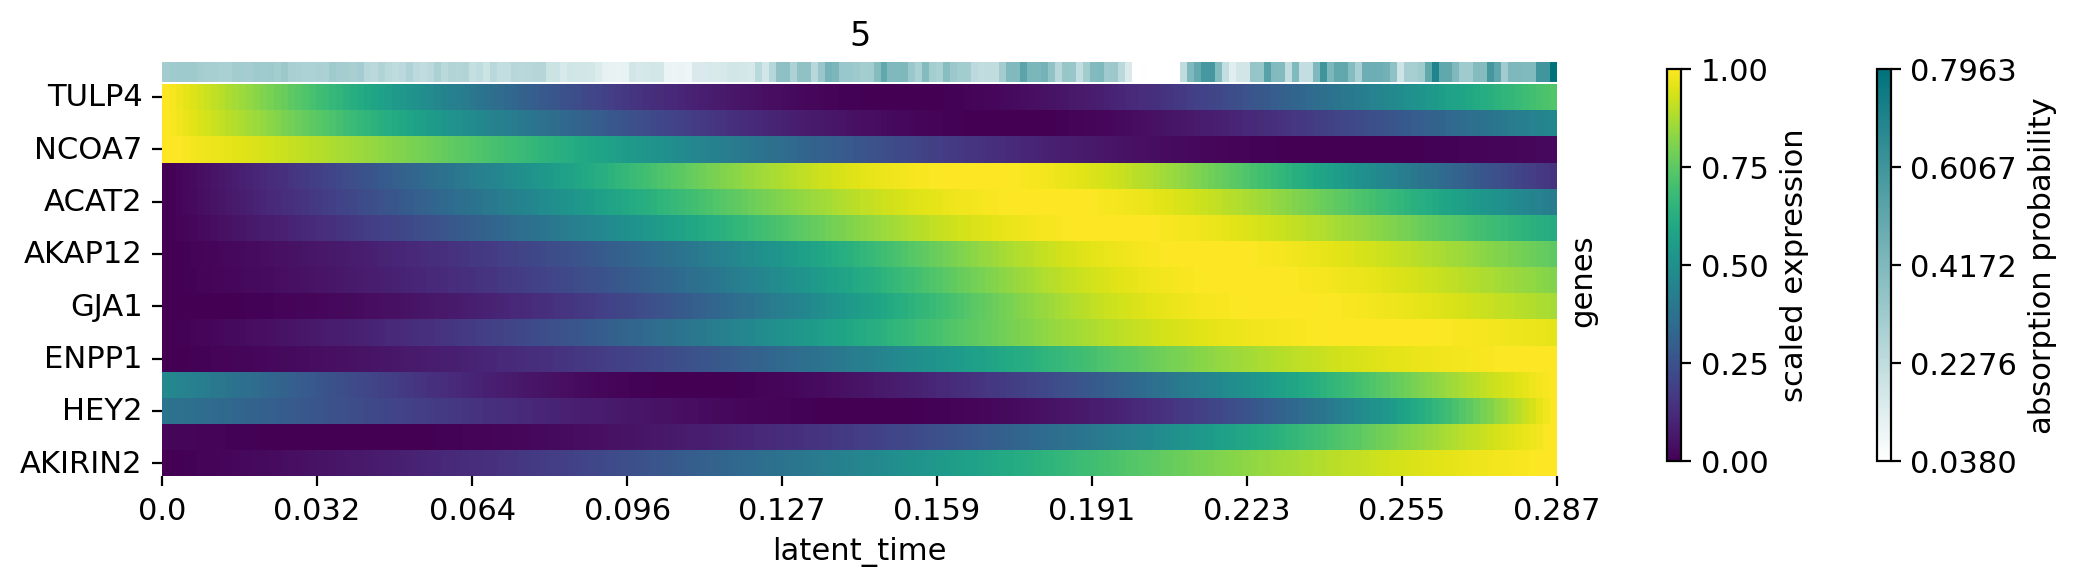

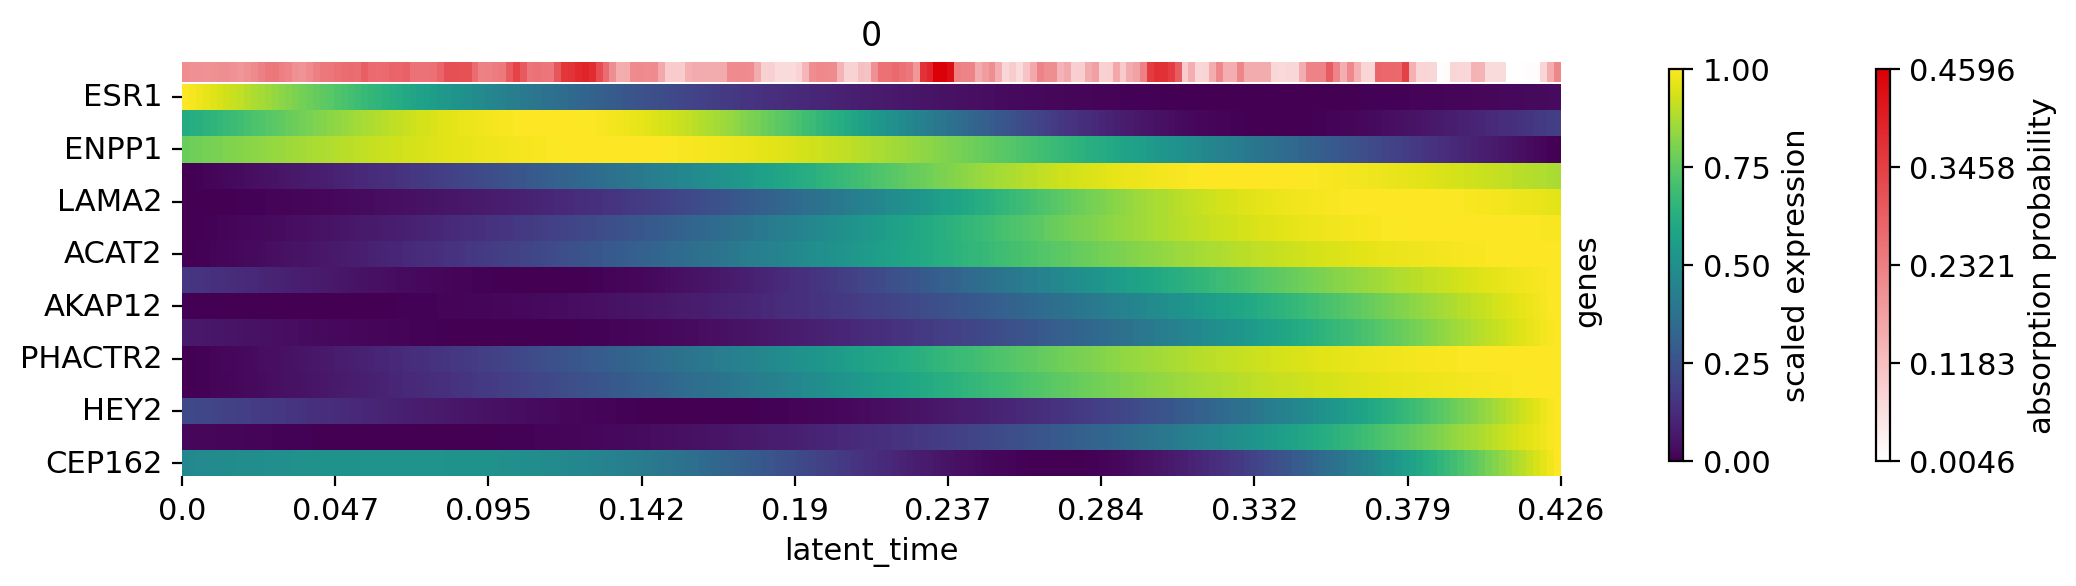

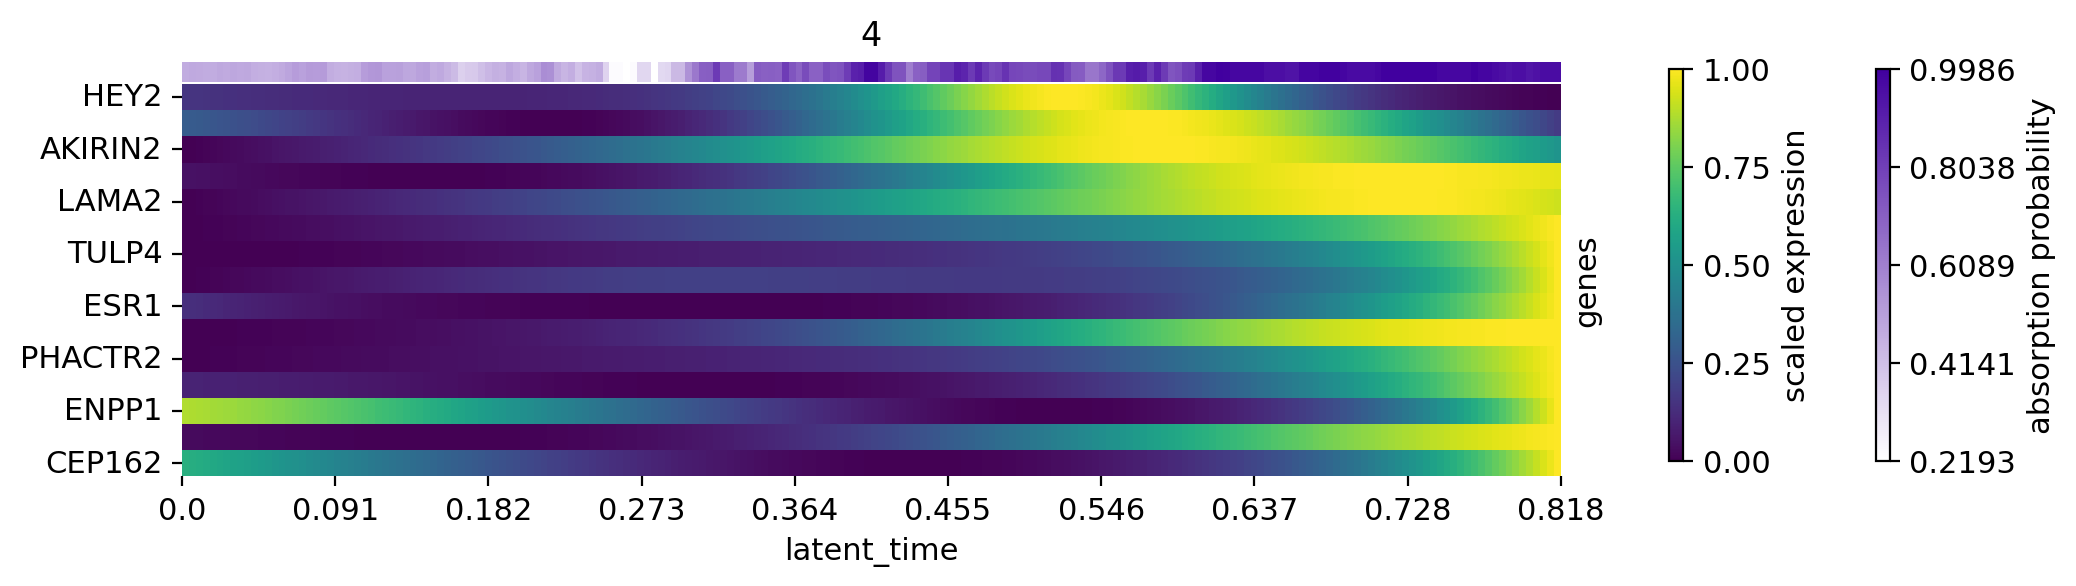

In [43]:
## 查看基因
genes = cr.pl.heatmap(
    adata,
    model,
    adata.var_names[:15],
    time_key="latent_time",
    data_key='Ms',
    #lineages=["Lineage 0", "Lineage 1","Lineage 2", "Lineage 3", "Lineage 4"],
    show_absorption_probabilities=True,
    show_progress_bar=False,
    return_genes=True,
)
genes

In [51]:
## 查看lineage 
import pandas as pd
test=pd.DataFrame(adata.varm['terminal_lineage_drivers'])
test
test.to_csv('/home/lab401_B/scRNA_downstream/cellrank/scRNA_pig_oogenesis/cellfate_DEGs.csv')

Computing trends using `1` core(s)


  0%|          | 0/100 [00:00<?, ?gene/s]

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

    Finish (0:00:05)


/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

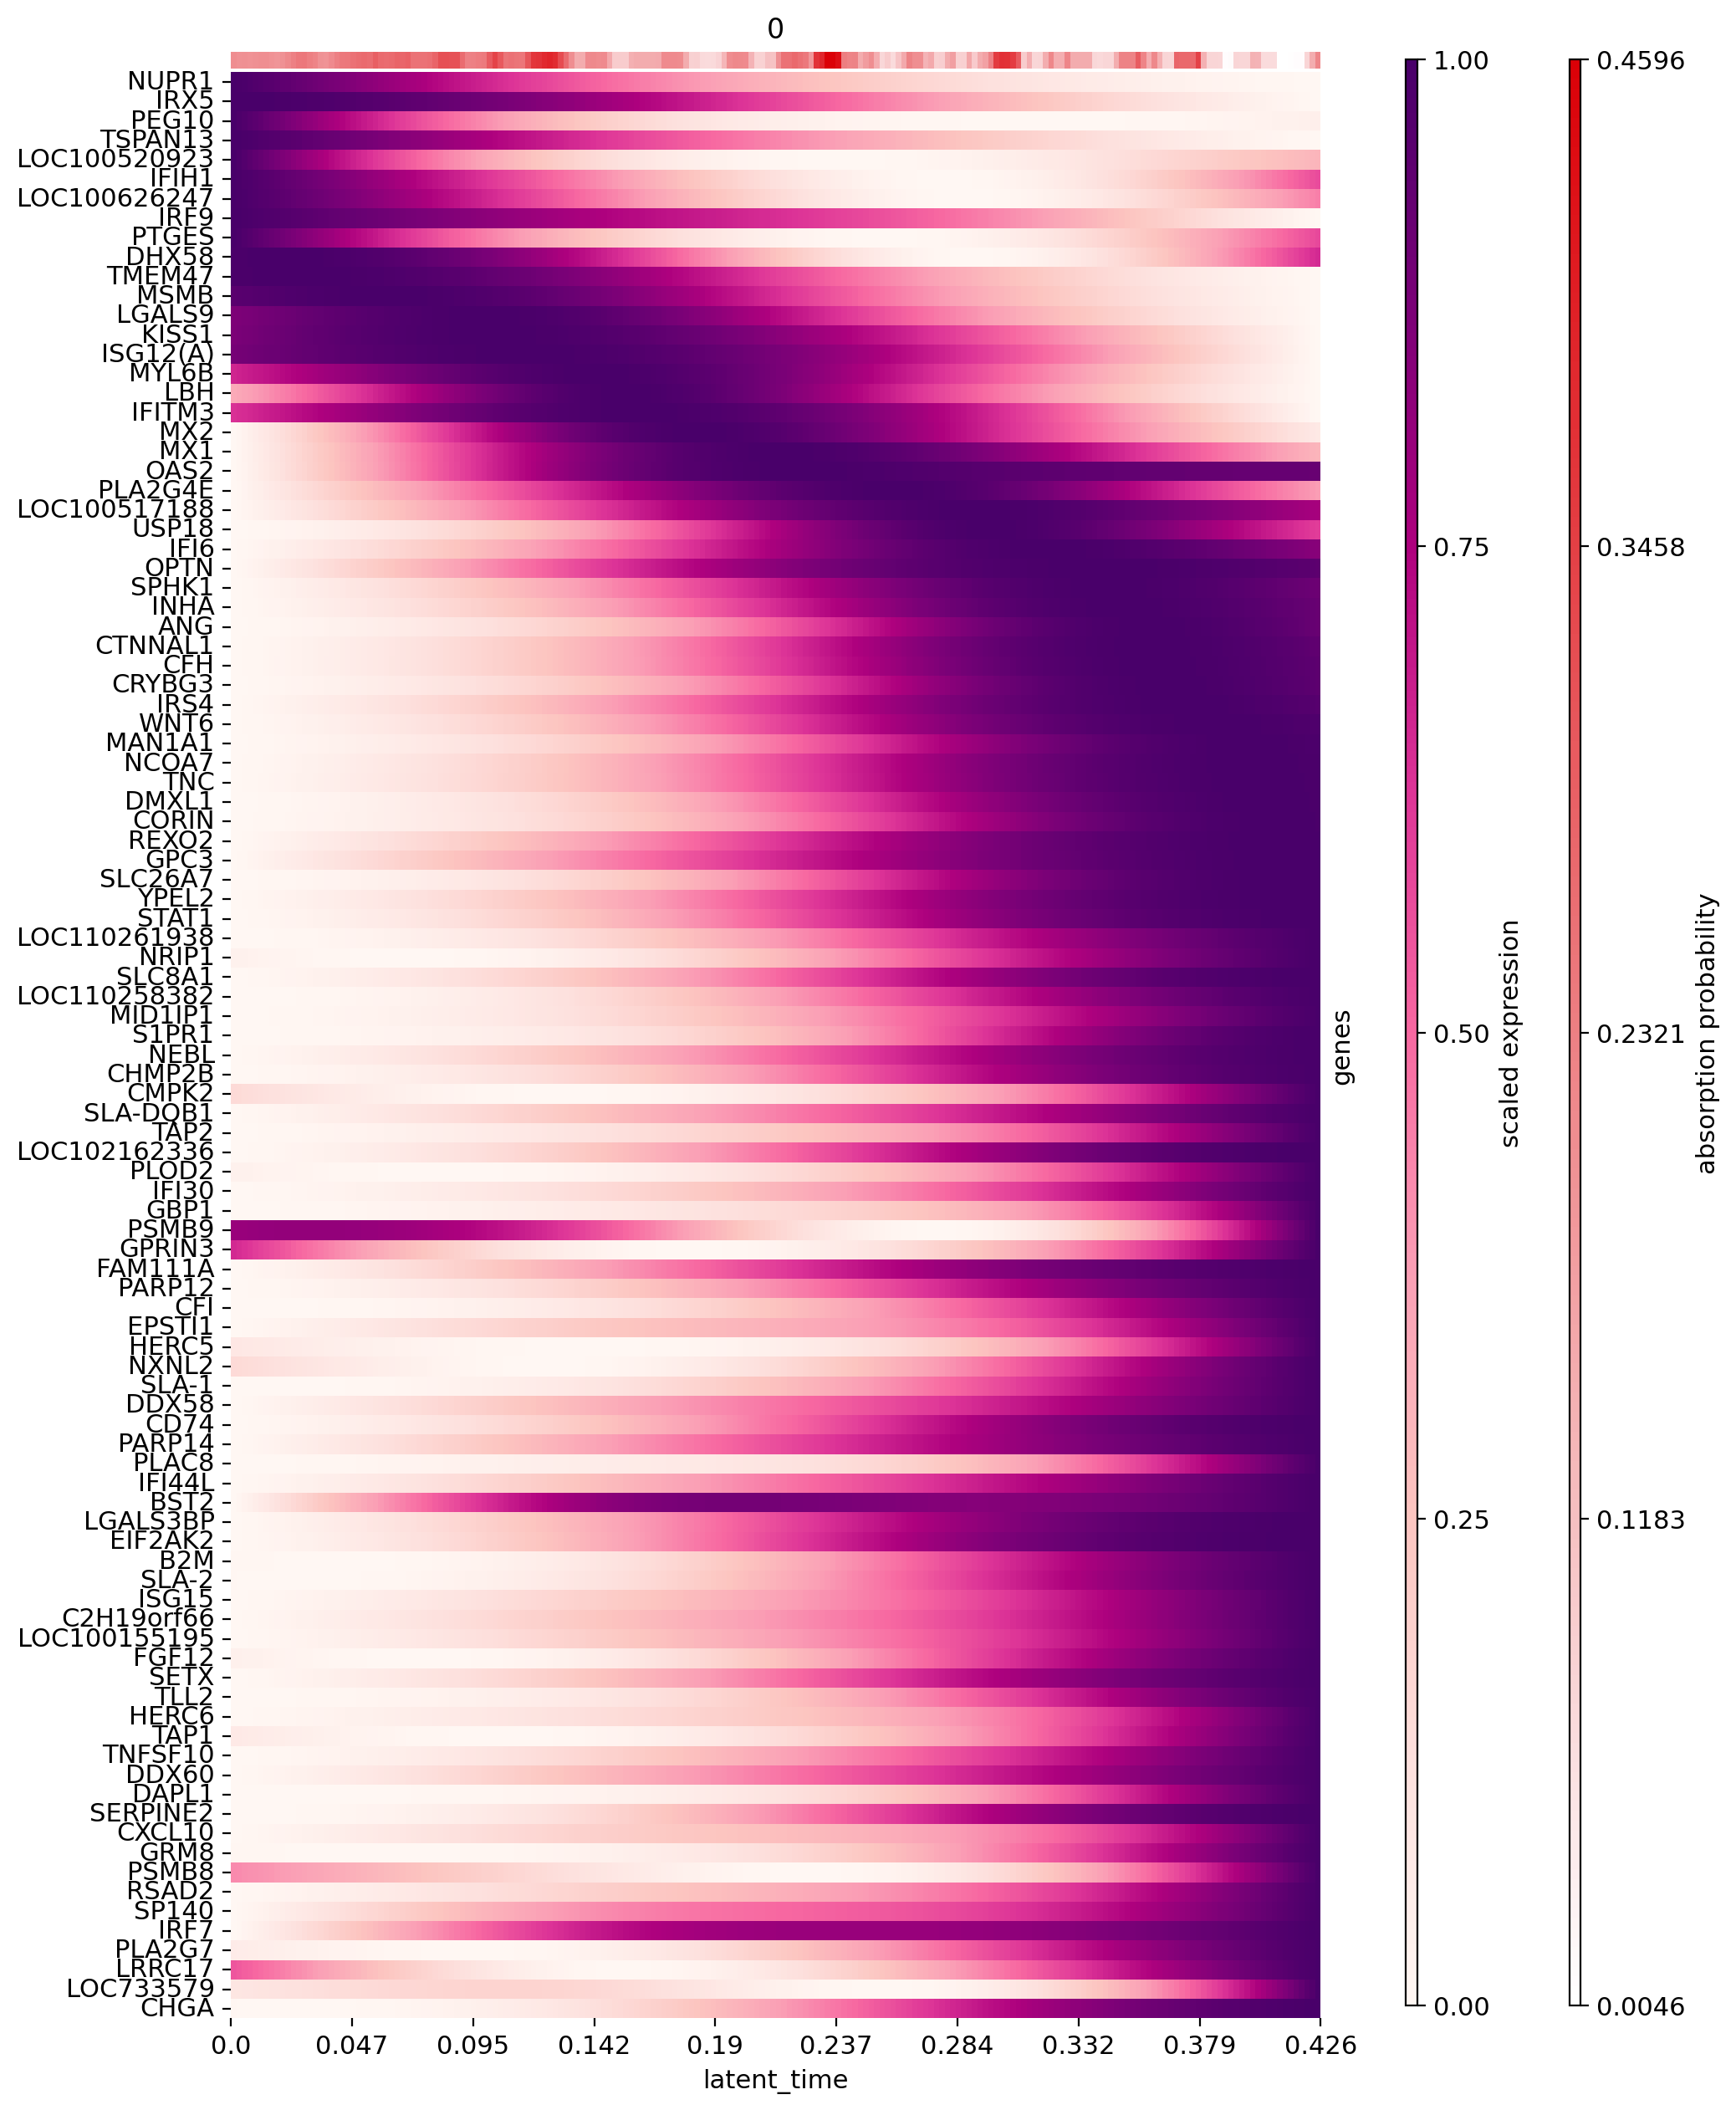

In [64]:
test = cr.pl.heatmap(
    adata,
    model,
    genes=adata.varm['terminal_lineage_drivers']["0_corr"].sort_values(ascending=False).index[:100], # 控制展示基因数量
    show_absorption_probabilities=True,
    show_all_genes=True,
    lineages="0",
    n_jobs=1,
    cmap="RdPu",
    backend="loky",
    figsize =(10,15),
    return_genes=True
    #save="heatmap_granulosa.pdf"
)
test.to_csv('/home/lab401_B/scRNA_downstream/cellrank/scRNA_pig_oogenesis/Heatmap_labels.csv')

Computing trends using `1` core(s)


  0%|          | 0/200 [00:00<?, ?gene/s]

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (x < aug_knots[1:]).astype(np.int)
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review y

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

    Finish (0:00:08)


/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/home/lab401_B/anaconda3/envs/cellrank/lib/python3.7/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wi

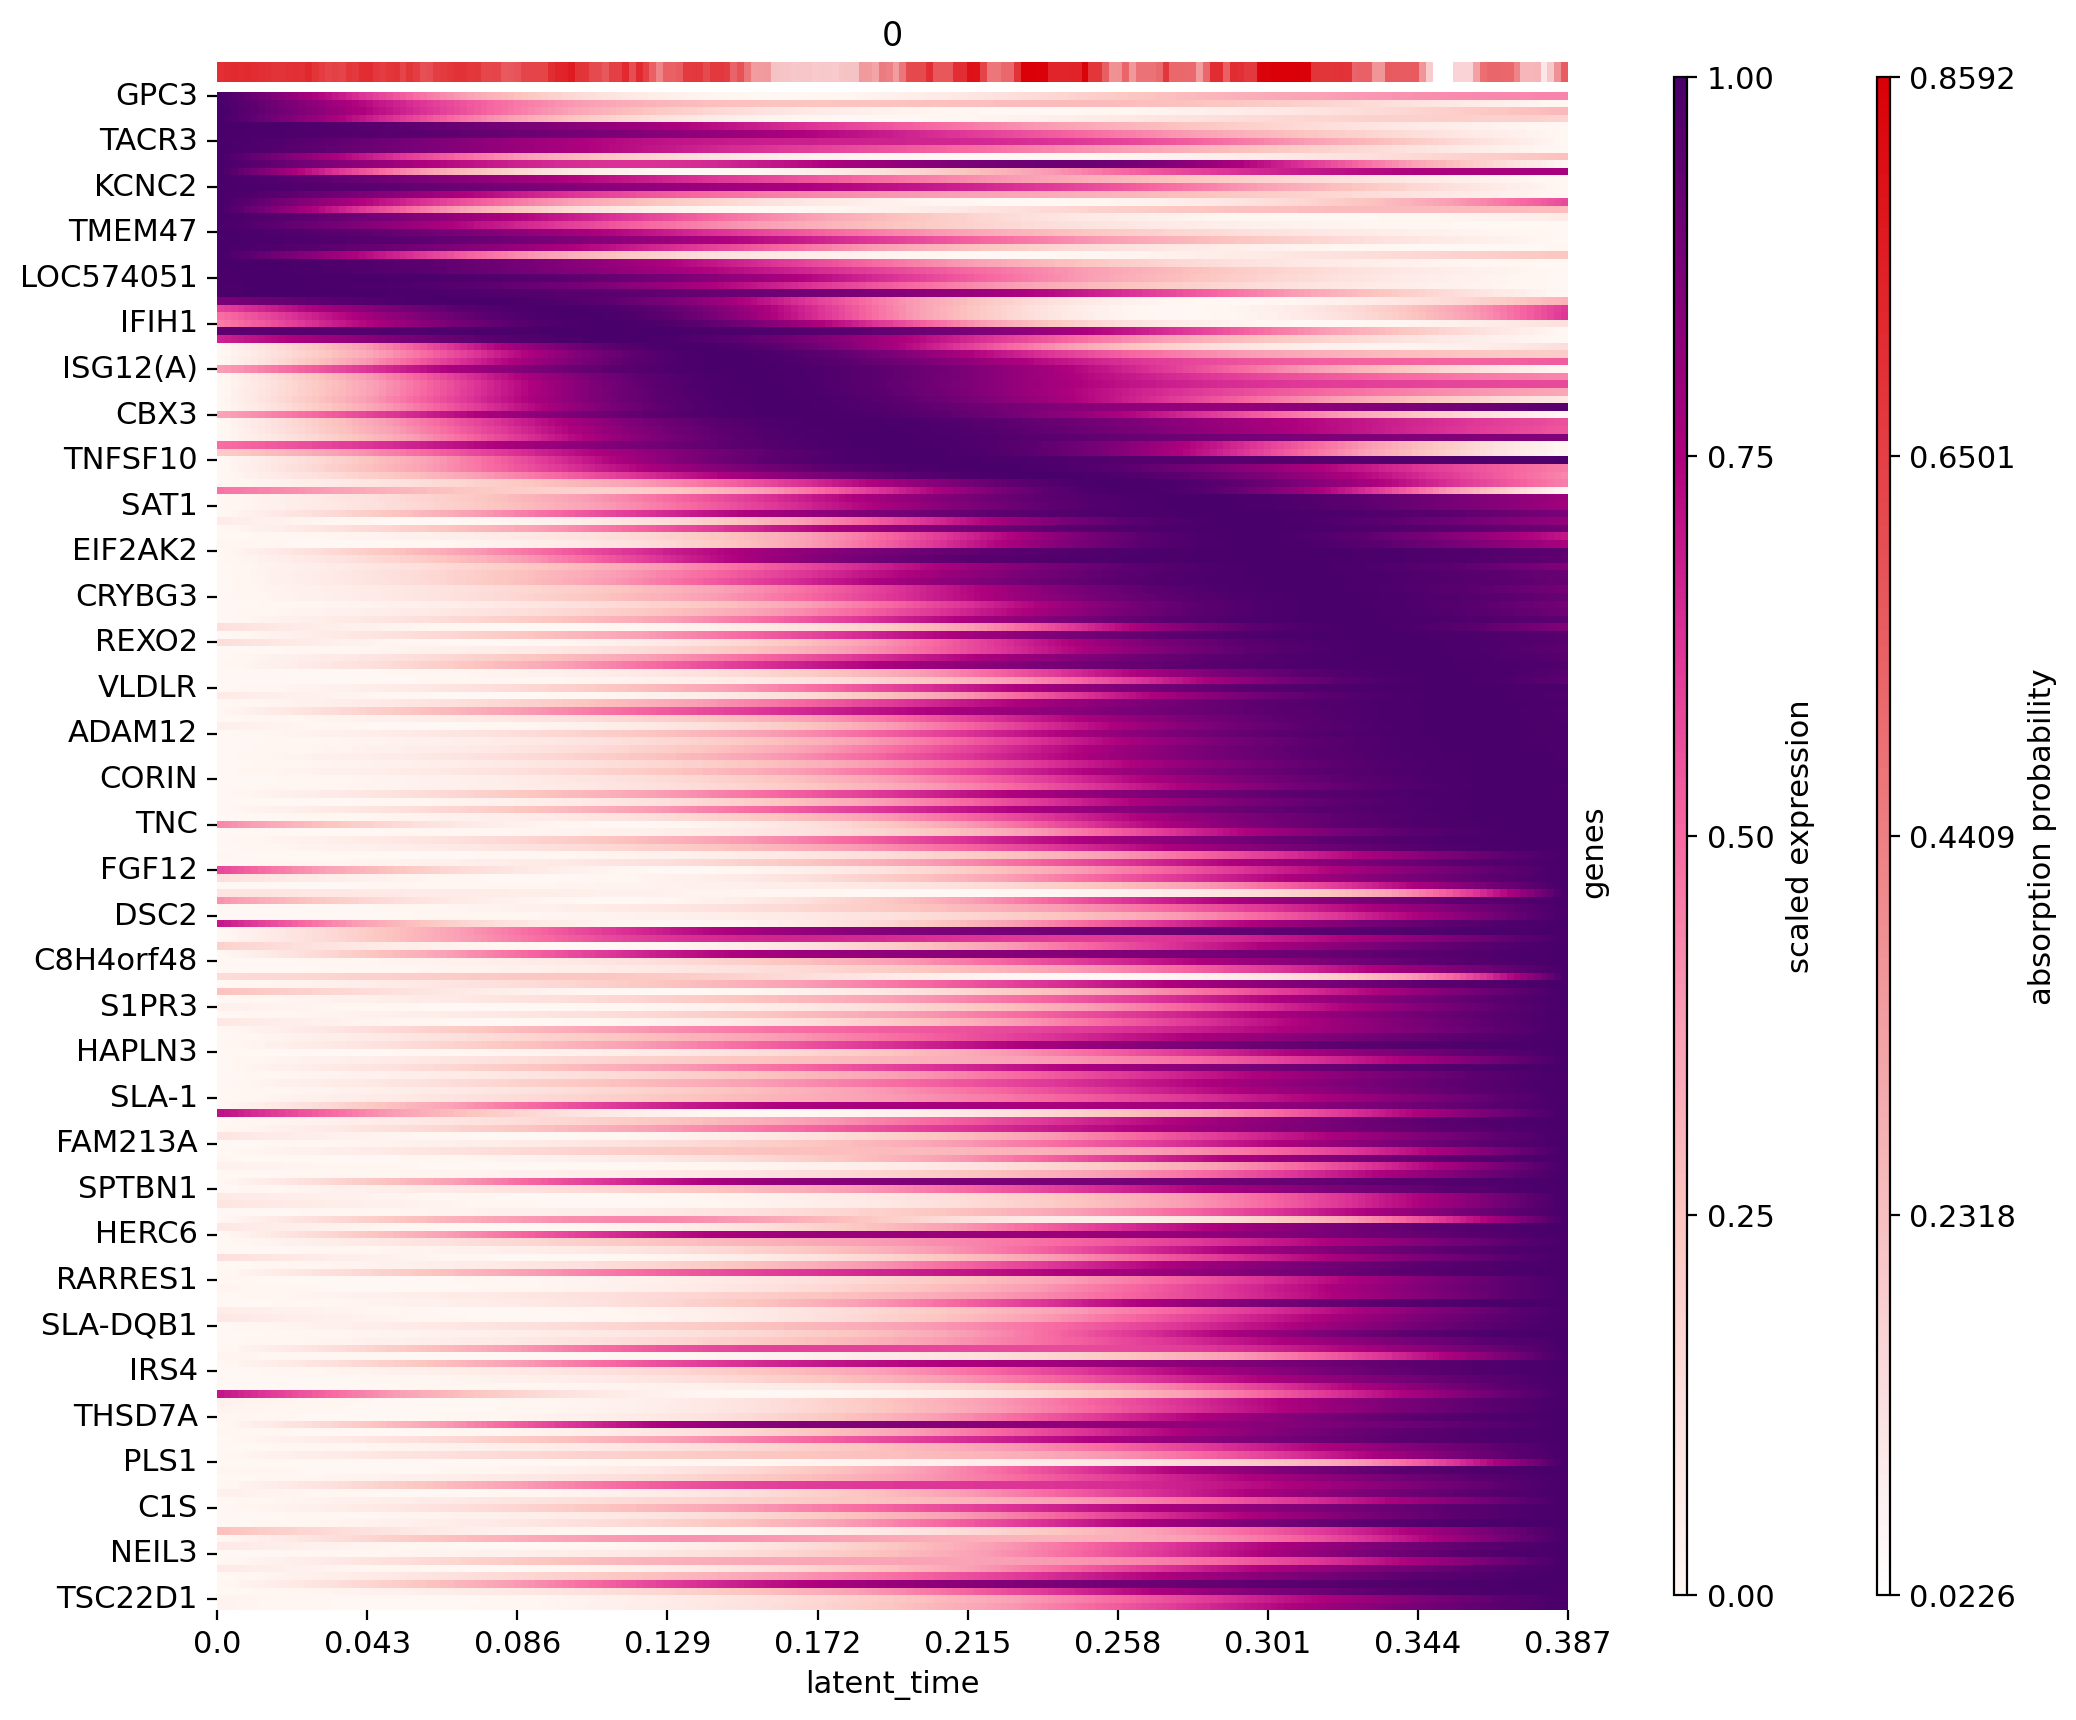

In [49]:
cr.pl.heatmap(
    adata,
    model,
    genes=adata.varm['terminal_lineage_drivers']["0_corr"].sort_values(ascending=False).index[:200],
    show_absorption_probabilities=True,
    lineages="0",
    n_jobs=1,
    cmap="RdPu",
    backend="loky",
)